<a href="https://colab.research.google.com/github/karthiknadar1204/generative_deep_learning/blob/main/DCGAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from google.colab import files

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 10
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d joosthazelzet/lego-brick-images
!unzip "/content/lego-brick-images.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset/43857 beam 1x2 300R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 301L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 301R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 302L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 302R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 303L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 303R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 304L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 304R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 305L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 305R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 306L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 306R.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 307L.png  
  inflating: /content/dataset/dataset/43857 beam 1x2 

In [5]:
train_data = utils.image_dataset_from_directory(
     "/content/dataset/LEGO brick images v1",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 6379 files belonging to 1 classes.


In [1]:
!ls /content/dataset/


ls: cannot access '/content/dataset/': No such file or directory


In [7]:
!ls "/content/dataset/LEGO brick images v1"

'11214 Bush 3M friction with Cross axle'  '3022 Plate 2x2'	      '3673 Peg 2M'
'18651 Cross Axle 2M with Snap friction'  '3023 Plate 1x2'	      '3713 Bush for Cross Axle'
'2357 Brick corner 1x2x2'		  '3024 Plate 1x1'	      '3794 Plate 1X2 with 1 Knob'
'3003 Brick 2x2'			  '3040 Roof Tile 1x2x45deg'  '6632 Technic Lever 3M'
'3004 Brick 1x2'			  '3069 Flat Tile 1x2'
'3005 Brick 1x1'			  '32123 half Bush'


In [8]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [9]:
train_sample = sample_batch(train)

NameError: name 'sample_batch' is not defined

In [ ]:
display(train_sample)

In [9]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [11]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):

        # Sample random points in the latent space.
        # We want to create random points in this 100-dimensional space.
        # These points will serve as input to the generator network.
        # The function tf.random.normal() generates random values from
        # a normal (Gaussian) distribution with a mean of 0 and a standard deviation of 1.
        # We specify the shape of the random points as (batch_size, self.latent_dim). Here, batch_size
        # is the number of samples in the current batch of real images, and self.latent_dim is 100.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )


        # Train the discriminator on fake images
        # This block starts a gradient tape context for both the generator (gen_tape) and discriminator (disc_tape).
        # It allows us to record operations for automatic differentiation, enabling us to compute gradients later
        # for backpropagation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:


            # The generator takes random latent vectors as input and generates fake images.
            # These images are produced using the current parameters of the generator.
            generated_images = self.generator(
                random_latent_vectors, training=True
            )


            # The discriminator evaluates both the real images (real_images) and the generated images (generated_images).
            # It produces predictions for each image, indicating whether it thinks the image is real or fake.
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )


            # We prepare labels for the discriminator's loss calculation. We create "real" labels (1s) for real images
            # and "fake" labels (0s) for generated images. Additionally, we add some noise to these labels to
            # introduce label smoothing, a regularization technique that makes the discriminator's job more challenging.
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )



            # We calculate the discriminator's loss. We compare the predictions of the discriminator
            # with the corresponding labels (real or fake) and compute the binary cross-entropy loss.
            # Finally, we average the loss over the real and fake samples.
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0



            # We calculate the generator's loss. The generator aims to fool the discriminator into classifying its
            # generated images as real. Therefore, we compare the discriminator's predictions on the generated
            # images with "real" labels.
            g_loss = self.loss_fn(real_labels, fake_predictions)



        # The subsequent lines compute the gradients of the discriminator and generator
        # losses with respect to their trainable variables, apply these gradients to update
        # the networks' parameters using their respective optimizers (d_optimizer and g_optimizer),
        # and update metrics to track the performance of both networks during training.
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [13]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

In [14]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [18]:
# Model checkpoint to save the model's weights
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=1  # Changed to 1 to see log messages when weights are saved
)

# TensorBoard callback for logging training progress
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors, training=False)
        generated_images = (generated_images * 127.5 + 127.5).numpy()  # Scale images to the [0, 255] range

        fig, axs = plt.subplots(1, self.num_img, figsize=(self.num_img * 2, 2))
        for i in range(self.num_img):
            axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
            axs[i].axis('off')
        plt.tight_layout()
        plt.savefig("./output/generated_img_%03d.png" % (epoch))
        plt.close()

# Ensure output directory exists
os.makedirs("./output", exist_ok=True)


In [22]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
 6/50 [==>...........................] - ETA: 6s - d_loss: -0.4622 - d_real_acc: 0.9974 - d_fake_acc: 0.9883 - d_acc: 0.9928 - g_loss: 10.4602 - g_acc: 0.0117

50/50 [==============================] - ETA: 0s - d_loss: -0.2856 - d_real_acc: 0.9585 - d_fake_acc: 0.9567 - d_acc: 0.9576 - g_loss: 8.6535 - g_acc: 0.0433
Epoch 1: saving model to ./checkpoint/checkpoint.ckpt
50/50 [==============================] - 9s 160ms/step - d_loss: -0.2856 - d_real_acc: 0.9585 - d_fake_acc: 0.9567 - d_acc: 0.9576 - g_loss: 8.6535 - g_acc: 0.0433
Epoch 2/10
50/50 [==============================] - ETA: 0s - d_loss: 0.2769 - d_real_acc: 0.8627 - d_fake_acc: 0.8600 - d_acc: 0.8613 - g_loss: 6.8187 - g_acc: 0.1400
Epoch 2: saving model to ./checkpoint/checkpoint.ckpt
50/50 [==============================] - 9s 161ms/step - d_loss: 0.2769 - d_real_acc: 0.8627 - d_fake_acc: 0.8600 - d_acc: 0.8613 - g_loss: 6.8187 - g_acc: 0.1400
Epoch 3/10
50/50 [==============================] - ETA: 0s - d_loss: 0.2921 - d_real_acc: 0.8509 - d_fake_acc: 0.8501 - d_acc: 0.8505 - g_loss: 4.9774 - g_acc: 0.1499
Epoch 3: saving model to ./checkpoint/checkpoint.ckpt
50/50 [==========

In [23]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

In [24]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [25]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 609ms/step


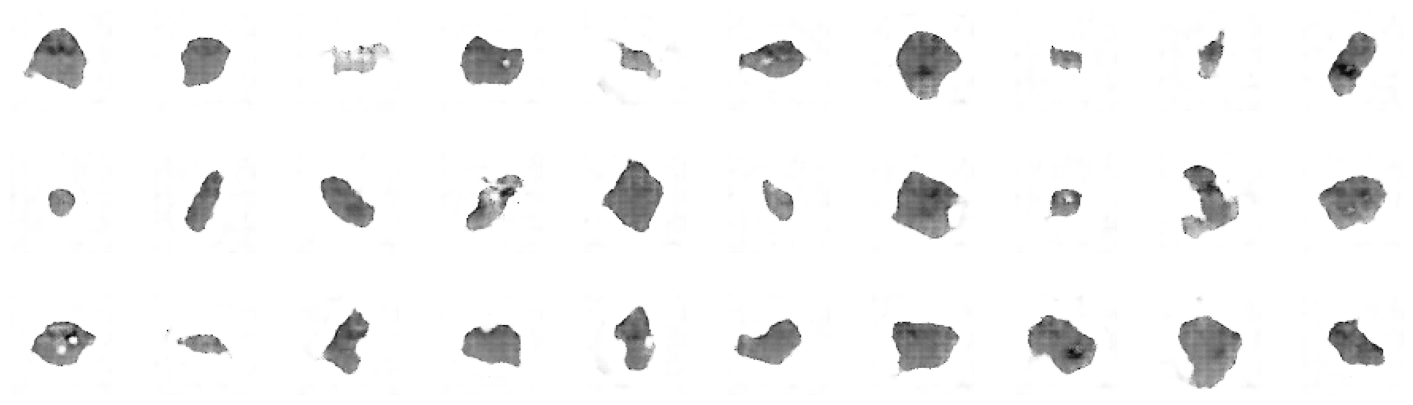

In [26]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [27]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [28]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 444ms/step


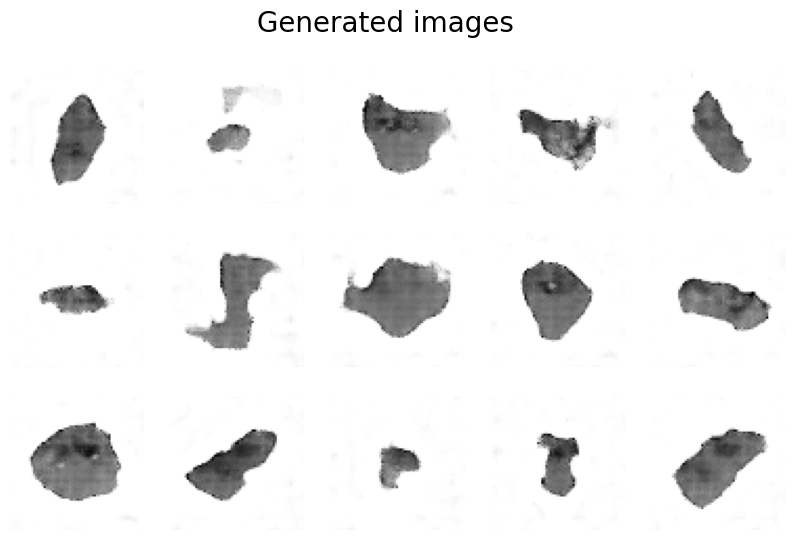

In [29]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

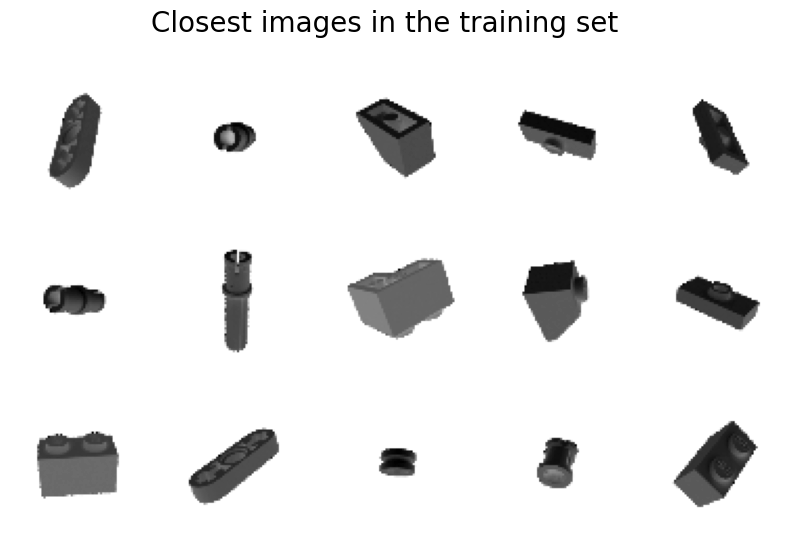

In [30]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()